In [1]:
# Libraries

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
data =  xr.open_dataset(r"G:/IMDAA_Regrid_1.08_1990_2022/IMDAA_merged_1.08_1990_2020.nc")
data

<xarray.Dataset>
Dimensions:   (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time      (time) datetime64[ns] 1990-01-01 ... 2020-12-31T18:00:00
    lat       (latitude) float64 ...
    lon       (longitude) float64 ...
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 ...
    TMP_prl   (time, latitude, longitude) float32 ...
    TMP_2m    (time, latitude, longitude) float32 ...
    APCP_sfc  (time, latitude, longitude) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear

In [3]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc'] # [H500, T850, T2m, TP6h]

In [80]:
ds = data['TMP_prl'] 
ds = ds.to_dataset()
ds


<xarray.Dataset>
Dimensions:  (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
Dimensions without coordinates: latitude, longitude
Data variables:
    TMP_prl  (time, latitude, longitude) float32 ...

In [105]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')
# prediction days ahead
lead_time_steps = 20 # consider the number of observations per day

In [106]:
def get_train_valid_test_dataset(lead_steps, Data_array):
  # Split train, valid and test dataset
  train_data = Data_array.sel(time=train_years)
  valid_data = Data_array.sel(time=valid_years)
  test_data = Data_array.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  # mean = train_data.mean(dim = "time")
  # std = train_data.std(dim = "time")
  
  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [107]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, ds)

In [71]:
mean

<xarray.Dataset>
Dimensions:  ()
Data variables:
    HGT_prl  float32 5.825e+03

In [128]:
std

<xarray.Dataset>
Dimensions:  ()
Data variables:
    TMP_prl  float32 5.831

In [108]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40888, 32, 32, 1)
(40888, 32, 32, 1)
(1440, 32, 32, 1)
(1440, 32, 32, 1)
(2904, 32, 32, 1)
(2904, 32, 32, 1)


### Evaluation Metrics

In [8]:
def compute_rmse(prediction, actual,  mean_dims = ('time', 'latitude', 'longitude')):
  error = prediction - actual
  rmse = np.sqrt(((error)**2 ).mean(mean_dims))
  return rmse

In [9]:
def compute_mae(prediction, actual, mean_dims = ('time', 'latitude', 'longitude')):
    error = prediction - actual
    mae = np.abs(error).mean(mean_dims)
    return mae

In [10]:
def compute_acc(prediction, actual):
    clim = actual.mean('time')
    try:
        t = np.intersect1d(prediction.time, actual.time)
        pred_anomaly = prediction.sel(time=t) - clim
    except AttributeError:
        t = actual.time.values
        pred_anomaly = prediction - clim
    act_anomaly = actual.sel(time=t) - clim
    
    pred_norm = pred_anomaly - pred_anomaly.mean()
    act_norm = act_anomaly - act_anomaly.mean()

    acc = (
            np.sum(pred_norm * act_norm) /
            np.sqrt(
                np.sum(pred_norm ** 2) * np.sum(act_norm ** 2)
            )
    )
    return acc

### CNN

In [11]:
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, GRU, LSTMCell
from keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Dropout, Conv3D
import warnings
warnings.filterwarnings('ignore')

In [63]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    # keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, 5, padding='same'),

    # No activation since we are solving a regression problem
])

In [145]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(learning_rate=1e-5), 'mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 32)        25632     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 32)        

In [132]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#create callback
filepath = 'D:/VSCODE_Works/BharatBench/ignore/IMDAA_CNN_H500_5days.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')



In [146]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 10,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history
history_cnn = fit_model(model)

Epoch 1/10
1278/1278 [==============================] - 93s 72ms/step - loss: 0.1281 - val_loss: 0.1466
Epoch 2/10
1278/1278 [==============================] - 94s 74ms/step - loss: 0.1283 - val_loss: 0.1466
Epoch 3/10
1278/1278 [==============================] - 98s 77ms/step - loss: 0.1281 - val_loss: 0.1468
Epoch 4/10
1278/1278 [==============================] - 89s 69ms/step - loss: 0.1279 - val_loss: 0.1468
Epoch 5/10
1278/1278 [==============================] - 94s 73ms/step - loss: 0.1281 - val_loss: 0.1467
Epoch 6/10
1278/1278 [==============================] - 101s 79ms/step - loss: 0.1279 - val_loss: 0.1468
Epoch 6: early stopping


In [142]:
# save the model
model.save('D:/VSCODE_Works/BharatBench/ignore/IMDAA_CNN_T850_5days_val_loss_0.1473.hdf5')

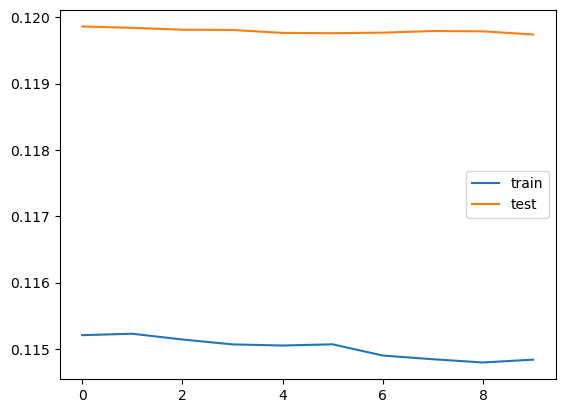

In [233]:
# plot training history
# print("Values stored in history are ... \n", history_cnn.history)
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.legend()
plt.show()

### Visualization of Model

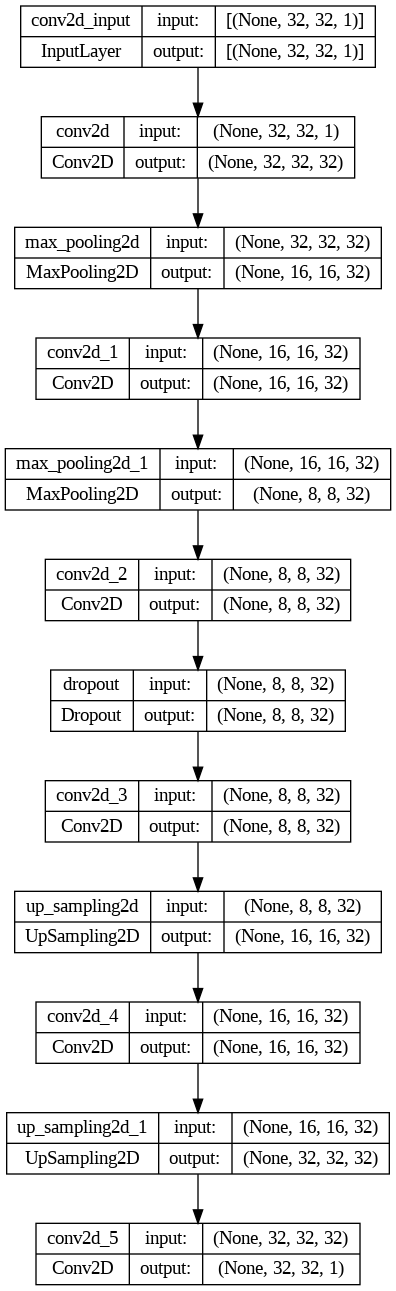

In [ ]:
# Visualize the architecture of the CNN
# tf.keras.utils.plot_model(model, to_file= "CNN_IMDAA.png", show_shapes=True)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import visualkeras

In [ ]:
visualkeras.layered_view(model, to_file='output.png').show()

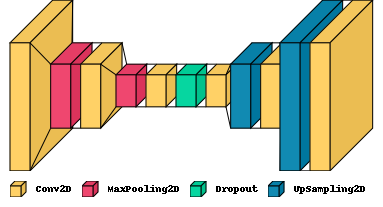

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume = 1)

### Evaluation of the Model

In [91]:
from keras.models import Sequential, load_model
model = load_model('D:\VSCODE_Works\BharatBench\ignore\IMDAA_CNN_T850_5days_val_loss_0.1473.hdf5')

In [92]:
target = ds.sel(time=test_years)
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 [==============================] - 2s 21ms/step
RMSE: 2.2565885
MAE 1.5778518
ACC 0.9155987


### convLSTM

In [109]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40888, 32, 32, 1)
(40888, 32, 32, 1)
(1440, 32, 32, 1)
(1440, 32, 32, 1)
(2904, 32, 32, 1)
(2904, 32, 32, 1)


In [110]:
X_train = X_train[:, np.newaxis,:,:,:]
Y_train = Y_train[:, np.newaxis,:,:,:]
X_valid = X_valid[:, np.newaxis,:,:,:]
Y_valid = Y_valid[:, np.newaxis,:,:,:]
X_test = X_test[:, np.newaxis,:,:,:]
Y_test = Y_test[:, np.newaxis,:,:,:]


In [14]:
# Build an convLSTM network
model = keras.Sequential([
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.UpSampling3D(size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.UpSampling3D(size=(1, 2, 2)),
    
    keras.layers.Conv3D(filters=1, kernel_size=(5, 5, 5),  padding="same")    
])

In [119]:
model.build((None, 1, 32, 32,  1))
model.compile(keras.optimizers.Adam(learning_rate=1e-6), 'mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_33 (ConvLSTM2D)  (None, 1, 32, 32, 32)    38144     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 1, 16, 16, 32)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_34 (ConvLSTM2D)  (None, 1, 16, 16, 32)    73856     
                                                                 
 dropout_11 (Dropout)        (None, 1, 16, 16, 32)     0         
                                                                 
 conv_lstm2d_35 (ConvLSTM2D)  (None, 1, 16, 16, 32)    73856     
                                                                 
 up_sampling3d_4 (UpSampling  (None, 1, 32, 32, 32)    0         
 3D)                                                 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#create callback
filepath = 'D:/VSCODE_Works/BharatBench/ignore/IMDAA_convlstm_H500_3days.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, verbose=1)

In [120]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 5,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history
history_cnn = fit_model(model)

Epoch 1/5
1278/1278 [==============================] - 286s 213ms/step - loss: 0.1777 - val_loss: 0.1723
Epoch 2/5
1278/1278 [==============================] - 273s 214ms/step - loss: 0.1776 - val_loss: 0.1723
Epoch 3/5
1278/1278 [==============================] - 262s 205ms/step - loss: 0.1776 - val_loss: 0.1724
Epoch 4/5
1278/1278 [==============================] - 257s 201ms/step - loss: 0.1776 - val_loss: 0.1724
Epoch 5/5
1278/1278 [==============================] - 260s 204ms/step - loss: 0.1776 - val_loss: 0.1724


In [115]:
model.save('D:/VSCODE_Works/BharatBench/ignore/IMDAA_convlstm_T850_5days_val_loss_0.1728.hdf5')

In [111]:
from keras.models import Sequential, load_model
model = load_model('D:\VSCODE_Works\BharatBench\ignore\IMDAA_convlstm_T850_5days_val_loss_0.1728.hdf5')

In [118]:
target = ds.sel(time=test_years)

pred_test = model.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 [==============================] - 5s 58ms/step
RMSE: 2.378975
MAE 1.6563131
ACC 0.9053788
